# Data exploration
This notebook contains some tests about data import and some data viz tools

In [152]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from pandas_profiling import ProfileReport
%matplotlib inline

# Characters

In [154]:
character_columns = ['wiki_movie_id', 'freebase_movie_id', 'm_release_date', 'name', 'a_dob', 'a_gender', 'a_height', 'a_ethnicity_freebase_id', 'a_name', 'a_age_at_release', 'freebase_char/a_map', 'freebase_char_id', 'freebase_a_id']
characters = pd.read_csv(CHARACTERS_FILE, sep='\t', names=character_columns, index_col=False)

characters['m_release_date'] = pd.to_datetime(characters['m_release_date'], format='%Y-%m-%d', errors='coerce')

print(characters.shape)
characters.head()   

(450669, 13)


,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [155]:
# generate profiling report
# profile_characters = ProfileReport(characters, title='Characters report')
# profile_characters.to_file(REPORT_FOLDER + "character_report_0.html")

# Import ethnicities

In [156]:
ethnicities = pd.read_csv(ETHNICITY_FILE, sep='\t', header=None, names=['freebase_ethnicity_id', 'ethnicity_name'])
ethnicities

,freebase_ethnicity_id,ethnicity_name
0,/m/0x67,African Americans
1,/m/064b9n,Omaha people
2,/m/041rx,Jewish people
3,/m/033tf_,Irish Americans
4,/m/04gfy7,Indian Americans
...,...,...
425,/m/09r2kh,peoples of the Caucasus
426,/m/02ry8mk,Sierra Leone Creole people
427,/m/029q52,Georgians
428,/m/026d074,Goans


In [157]:
characters = pd.merge(left=characters, right=ethnicities, left_on='a_ethnicity_freebase_id', right_on='freebase_ethnicity_id', how='left')
characters = characters.drop(['freebase_ethnicity_id'], axis=1)
characters = characters.rename({'a_ethnicity_freebase_id': 'freebase_ethnicity_id'})
characters

,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id,ethnicity_name
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957-01-01,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957-01-01,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


# Import tvtropes
Import tv tropes to assign a trope to characters

In [158]:
tropes = pd.read_csv(TROPES_FILE, sep='\t', header=None, names=['trope', 'props'])
tropes

,trope,props
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
...,...,...
496,young_gun,"{""char"": ""Morgan Earp"", ""movie"": ""Tombstone"", ..."
497,young_gun,"{""char"": ""Colorado Ryan"", ""movie"": ""Rio Bravo""..."
498,young_gun,"{""char"": ""Tom Sawyer"", ""movie"": ""The League of..."
499,young_gun,"{""char"": ""William H. 'Billy the Kid' Bonney"", ..."


In [159]:
def split_tropes_props(x):
    res = {'trope': x['trope']}
    res.update(ast.literal_eval(x['props']))
    return res

tropes = tropes.apply(split_tropes_props, axis=1, result_type='expand')
tropes = tropes.rename(columns={'id': 'freebase_char/a_map'})
tropes

,trope,char,movie,freebase_char/a_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [160]:
# problem: we only have 501 characters tropes
characters_tropes = pd.merge(left=characters, right=tropes, on='freebase_char/a_map', how='inner')
characters_tropes

,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id,ethnicity_name,trope,char,movie,actor
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,Jewish people,tranquil_fury,David Sumner,Straw Dogs,Dustin Hoffman
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,NaN,granola_person,Sheldon Mopes,Death to Smoochy,Edward Norton
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,Jewish people,playful_hacker,Mr. Universe,Serenity,David Krumholtz
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,Jewish people,charmer,Harold Hill,The Music Man,Matthew Broderick
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,Jewish people,loveable_rogue,Harold Hill,The Music Man,Matthew Broderick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,101954,/m/0pv3x,1996-11-06,Geoffrey Clifton,1960-09-10,M,1.87,/m/0d7wh,Colin Firth,36.0,/m/0k4_tz,/m/0c0fwm8,/m/03f1zdw,British people,crazy_jealous_guy,Geoffrey Clifton,The English Patient,Colin Firth
497,9513043,/m/02ph9tm,2008-06-06,Zohan,1966-09-09,M,1.78,/m/041rx,Adam Sandler,41.0,/m/03hqx35,/m/0cb03np,/m/0pz91,Jewish people,warrior_poet,Zohan,You Don't Mess with the Zohan,Adam Sandler
498,52549,/m/0dtfn,1977-05-25,Han Solo,1942-07-13,M,1.85,/m/01qhm_,Harrison Ford,34.0,/m/0k3r1_,/m/0fjn8,/m/0c0k1,German Americans,charmer,Han Solo,Star Wars Episode IV: A New Hope,Harrison Ford
499,52549,/m/0dtfn,1977-05-25,Han Solo,1942-07-13,M,1.85,/m/01qhm_,Harrison Ford,34.0,/m/0k3r1_,/m/0fjn8,/m/0c0k1,German Americans,loveable_rogue,Han Solo,Star Wars Episode IV: A New Hope,Harrison Ford


# Movies

In [161]:
movies_columns = ['wiki_movie_id', 'freebase_movie_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv(MOVIES_FILE, sep='\t', names=movies_columns)

print(movies.shape)
movies.head()

(81741, 9)


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [162]:
# generate profiling report
# profile_movies = ProfileReport(movies, title='Movies report')
# profile_movies.to_file(REPORT_FOLDER + "movies_report_0.html")

In [163]:
# Clean dates
# Remember that one movie contains 1010 date. We need to check what to do with it. Movie : Hunting Season, changes by hand at the moment
# Note: use .dt.date to recover the date only (not the datetime part)
print("Number of nan movies release dates: ", movies['release_date'].isna().sum())
movies['release_date'] = pd.to_datetime(movies['release_date'], format='%Y-%m-%d', errors='coerce')
movies.head()

Number of nan movies release dates:  6902


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [164]:
print("Number of movies with box office revenue indicated: {} ({:.2%})".format(movies.shape[0] - movies['box_office_revenue'].isna().sum(), (movies.shape[0] - movies['box_office_revenue'].isna().sum())/movies.shape[0]))

# keep only movies with box office revenue
movies_without_na = movies[movies['box_office_revenue'].notna()]
print(movies_without_na.shape)

Number of movies with box office revenue indicated: 8401 (10.28%)
(8401, 9)


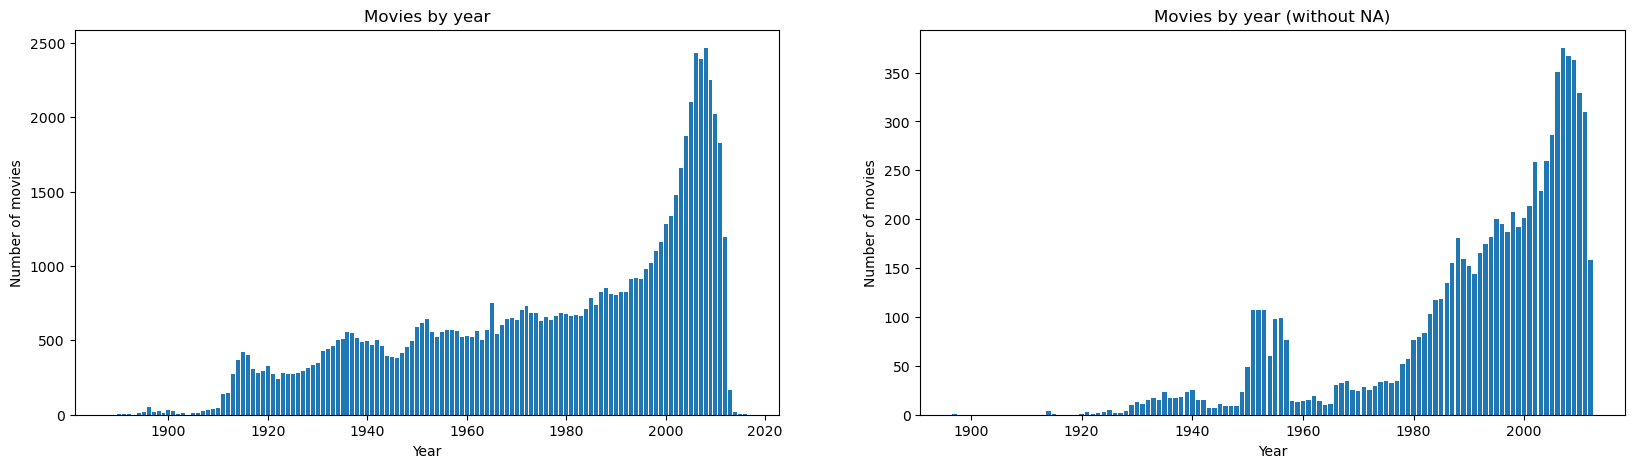

In [165]:
movies_by_year = movies.groupby(movies['release_date'].dt.year)['release_date'].count()
movies_by_year_without_na = movies_without_na.groupby(movies_without_na['release_date'].dt.year)['release_date'].count()

# plot values
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Movies by year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of movies')
ax[0].bar(movies_by_year.index, movies_by_year.values)
# ax[0] = plt.bar(x=movies_by_year.index, y=movies_by_year.values, ax=ax[0], color='lightblue')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

ax[1].set_title('Movies by year (without NA)')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Number of movies')
ax[1].bar(movies_by_year_without_na.index, movies_by_year_without_na.values)
plt.show()

In [166]:
## Get box office revenue by year
movies = movies_without_na
movies['box_office_revenue'] = movies['box_office_revenue'].astype(int)


In [167]:
def sort_by_box_office_revenue(df, k=10):
    return df.sort_values(by='box_office_revenue', ascending=False).head(k)

movies_by_year = movies.groupby(movies['release_date'].dt.year).apply(sort_by_box_office_revenue)
movies_by_year

wiki_movie_id freebase_movie_id  \
release_date                                          
1897.0       48417       28703057        /m/0czdh_n   
1914.0       49852       15130915        /m/03hjhh9   
             53319       15340505        /m/03m5kln   
             50991        1762869         /m/05tz4w   
             1026        14613957        /m/03gqmqv   
...                           ...               ...   
2012.0       78373       31186339        /m/0gkz15s   
             22008       13049327        /m/0661m4p   
             13702       16839300        /m/0407yfx   
             51913       31201599        /m/0gj9tn5   
             12076       31775043        /m/0gd0c7x   

                                             name release_date  \
release_date                                                     
1897.0       48417  The Corbett-Fitzsimmons Fight   1897-05-22   
1914.0       49852     The Million Dollar Mystery   1914-06-22   
             53319             Neptune's Daughter   1914-04-25   
             50991                  The Squaw Man   1914-02-15   
             1026              Rose of the Rancho   1914-11-15   
...                                           ...          ...   
2012.0       78373               The Hunger Games   2012-03-12   
             22008                 Men in Black 3   2012-05-14   
             13702                          Brave   2012-06-10   
             51913                            Ted   2012-06-29   
             12076                     Prometheus   2012-05-30   

                    box_office_revenue  runtime  \
release_date                                      
1897.0       48417              100000      NaN   
1914.0       49852             1500000      NaN   
             53319             1000000      NaN   
             50991              244700     74.0   
             1026                87028      NaN   
...                                ...      ...   
2012.0       78373           686533290    142.0   
             22008           624026776    103.0   
             13702           531957538     95.0   
             51913           488965740    106.0   
             12076           402480000    124.0   

                                                            languages  \
release_date                                                            
1897.0       48417                                                 {}   
1914.0       49852                 {"/m/02h40lc": "English Language"}   
             53319                 {"/m/02h40lc": "English Language"}   
             50991  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
             1026   {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
...                                                               ...   
2012.0       78373                 {"/m/02h40lc": "English Language"}   
             22008                 {"/m/02h40lc": "English Language"}   
             13702                 {"/m/02h40lc": "English Language"}   
             51913                 {"/m/02h40lc": "English Language"}   
             12076  {"/m/01ncmg": "Gaelic", "/m/02h40lc": "English...   

                                                    countries  \
release_date                                                    
1897.0       48417                                         {}   
1914.0       49852  {"/m/09c7w0": "United States of America"}   
             53319  {"/m/09c7w0": "United States of America"}   
             50991  {"/m/09c7w0": "United States of America"}   
             1026   {"/m/09c7w0": "United States of America"}   
...                                                       ...   
2012.0       78373  {"/m/09c7w0": "United States of America"}   
             22008  {"/m/09c7w0": "United States of America"}   
             13702  {"/m/09c7w0": "United States of America"}   
             51913  {"/m/09c7w0": "United States of America"}   
             12076  {"/m/09c7w0": "United States of

# Import summaries

In [168]:
summaries = pd.read_csv(PLOT_SUMMARIES_FILE, sep='\t', index_col=0, names=['plot'])
summaries.index.name = 'wiki_movie_id'
summaries.head()

,plot
wiki_movie_id,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


# Merge dataframes

In [169]:
# Movies and characters
# Here, we do a left join in order to keep all characters
# Note that we remove the release date field from the movie table and not from the character table, since it happens that characters have this info but we don't have any other info about the movie
df = pd.merge(left=characters, right=movies, on='wiki_movie_id', how='left', suffixes=('_c', '_m'))
duplicate_columns = ['freebase_movie_id_c', 'release_date']
df = df.drop(duplicate_columns, axis=1)
df = df.rename(columns={'freebase_movie_id_m': 'freebase_movie_id', 'name_c': 'char_name', 'name_m': 'movie_name', 'ethnicity_name': 'a_ethnicity', 'm_release_date': 'release_date'})

# Merge movies, characters and summaries
# Here, we do do a left join too, because we may want to have info relating the plots and the character, even without having info on the movie
# However, if other information are required, it could be better to join movies and summaries before merging with characters, in order to select only plots for which we have movies info
df = pd.merge(left=df, right=summaries, on='wiki_movie_id', how='left')

In [170]:
# Clean features by removing freebase id if they're not useful
def extract_feature(x):
    if x is np.nan:
        return np.nan
    return ', '.join(ast.literal_eval(x).values())

df['genres'] = df['genres'].apply(extract_feature)
df['languages'] = df['languages'].apply(extract_feature)
df['countries'] = df['countries'].apply(extract_feature)

# change order of columns
df = df[['wiki_movie_id','freebase_movie_id','movie_name','release_date','box_office_revenue','runtime','genres','languages','countries','plot','char_name','a_name','a_gender','a_ethnicity','a_dob','a_age_at_release','a_height','freebase_char/a_map','freebase_char_id','freebase_a_id','a_ethnicity_freebase_id']]

# print all columns and more rows
pd.set_option('display.max_columns', None)
df

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,plot,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height,freebase_char/a_map,freebase_char_id,freebase_a_id,a_ethnicity_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Akooshay,Wanda De Jesus,F,NaN,1958-08-26,42.0,1.620,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,1974-08-15,27.0,1.780,/m/0jys3m,/m/0bgchn4,/m/0346l4,/m/044038p
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Desolation Williams,Ice Cube,M,African Americans,1969-06-15,32.0,1.727,/m/0jys3g,/m/0bgchn_,/m/01vw26l,/m/0x67
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Sgt Jericho Butler,Jason Statham,M,NaN,1967-09-12,33.0,1.750,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Bashira Kincaid,Clea DuVall,F,NaN,1977-09-25,23.0,1.650,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,NaN,NaN,1992-05-21,NaN,NaN,NaN,NaN,NaN,"The story takes place in the year 2092,The Sup...",Elensh,Dorothy Elias-Fahn,F,NaN,1970-05,NaN,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,NaN,NaN,1992-05-21,NaN,NaN,NaN,NaN,NaN,"The story takes place in the year 2092,The Sup...",Hibiki,Jonathan Fahn,M,NaN,1965-04-12,27.0,NaN,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,NaN,NaN,1957-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,David Hemmings,M,English people,1941-11-18,15.0,1.730,/m/0g8ngmc,NaN,/m/022g44,/m/02w7gg
450667,28308153,NaN,NaN,1957-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,NaN,NaN,NaN,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


## Display top 10 ethnicities by decade

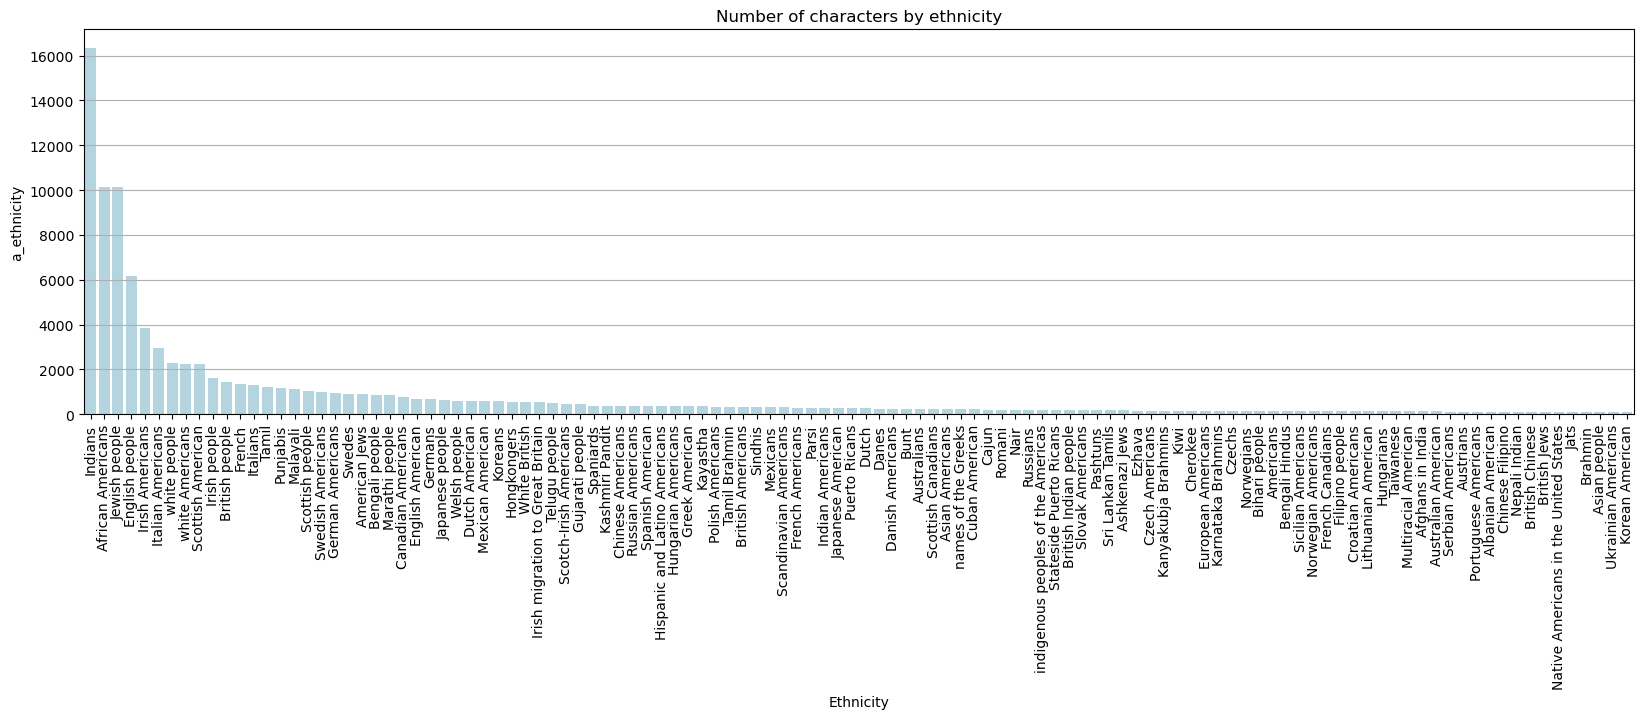

In [171]:
# plot the number of characters of each ethnicity
ethnicity_count = df['a_ethnicity'].value_counts()
ethnicity_count = ethnicity_count[ethnicity_count > 100]

fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Number of characters by ethnicity') 
sns.barplot(x=ethnicity_count.index, y=ethnicity_count, color='lightblue', ax=ax)
# sns.countplot(x=ethnicity_count, color='lightblue', ax=ax)
ax.set_xlabel('Ethnicity')
plt.xticks(rotation=90)
plt.grid(axis='y') #{'major', 'minor', 'both'}
plt.show()

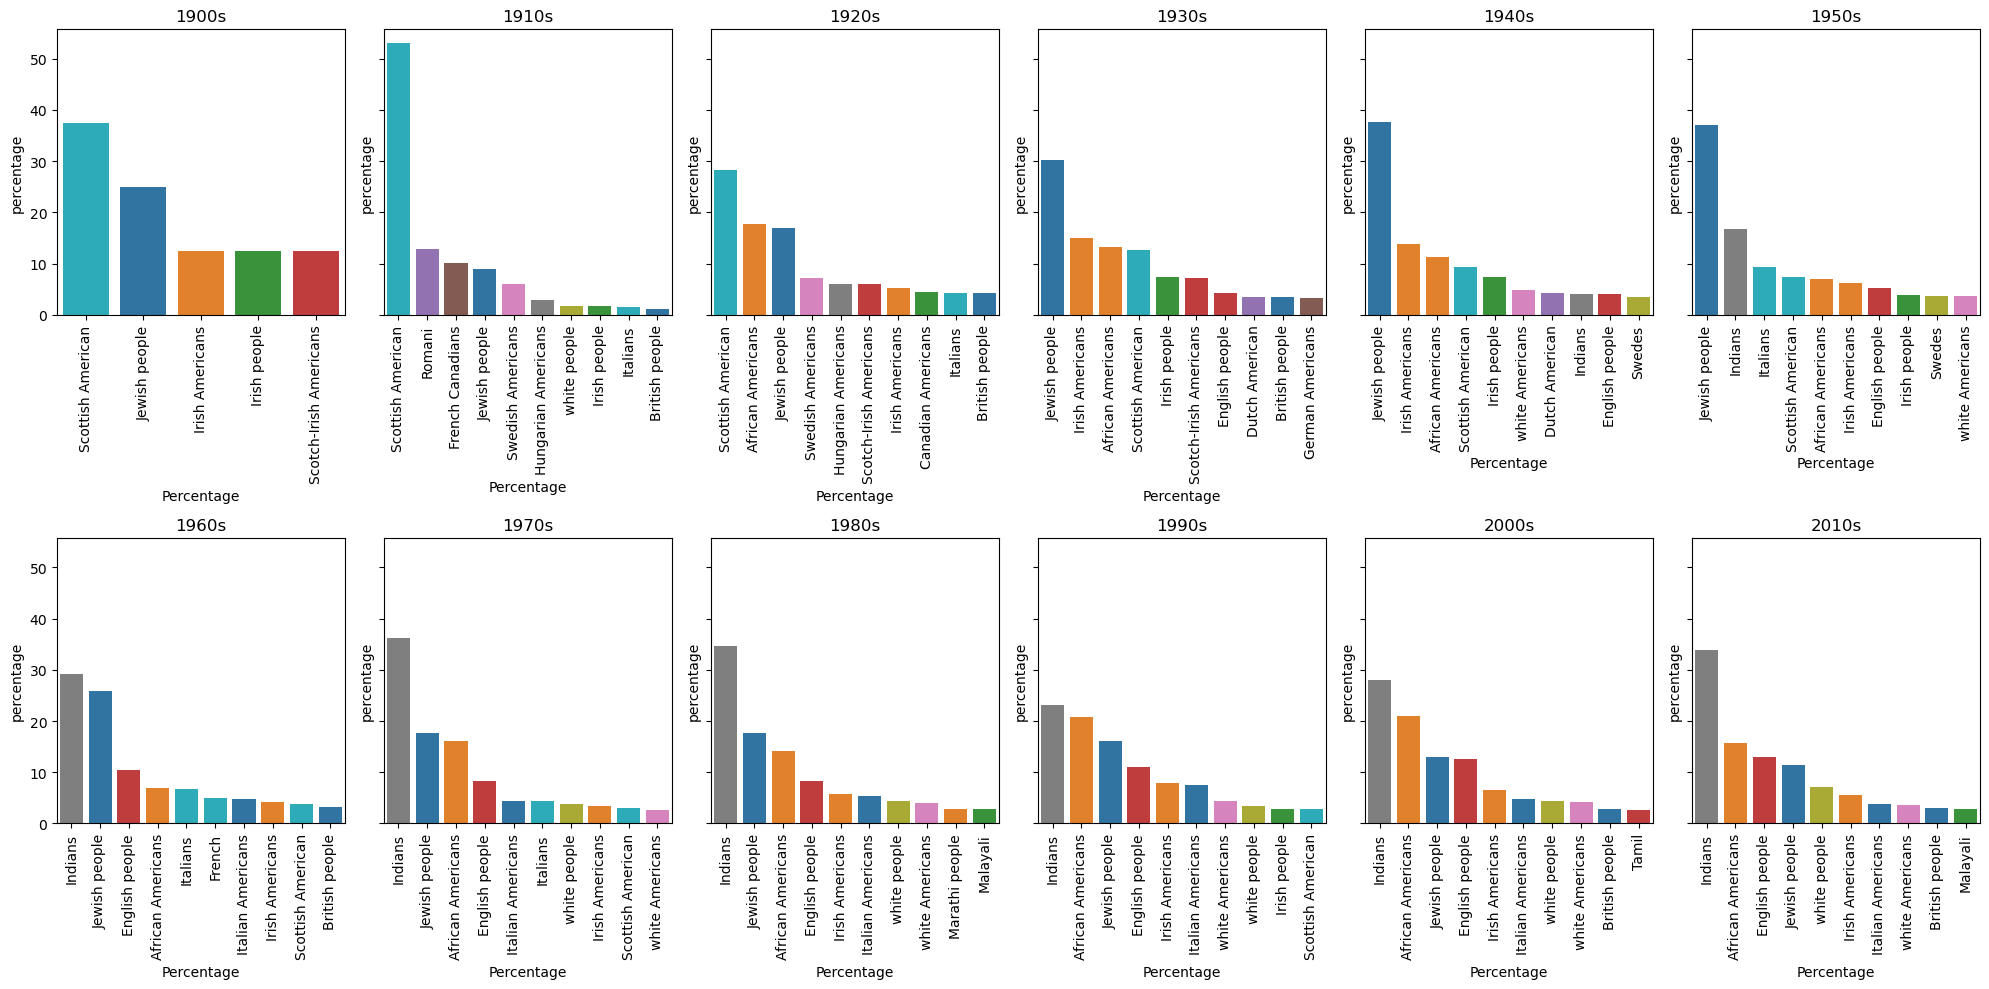

In [172]:
# count instances of ethnicities for each year
df1 = characters[~characters['ethnicity_name'].isna()]

# from https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
ethnicity_count = df1.groupby([df1['m_release_date'].dt.year // 10 * 10, df1['ethnicity_name']]).count()[['wiki_movie_id']]
# gen a "pretty" and usable dataset
ethnicity_count = ethnicity_count.rename(columns={'wiki_movie_id': 'count'})
ethnicity_count = ethnicity_count.reset_index() # level=1
ethnicity_count = ethnicity_count.rename(columns={'m_release_date': 'm_release_decade'})
ethnicity_count['m_release_decade'] = ethnicity_count['m_release_decade'].astype(int)

# get top k ethnicites for each decade
top_k = 10
decades = ethnicity_count['m_release_decade'].unique()

fig, ax = plt.subplots(2, 6, figsize=(20, 10), sharey=True)
ax = ax.flatten()
colors = {}

for i, decade in enumerate(decades[1:]): # TODO the 1890 movies are not displayed
    # get top k ethnicites
    df_top_k = ethnicity_count[ethnicity_count['m_release_decade'] == decade].sort_values(by='count', ascending=False).head(top_k)

    # percentage of the top k
    total = df_top_k['count'].sum()
    df_top_k['percentage'] = df_top_k['count'].apply(lambda x: x / total * 100)
    
    for ethnicity in df_top_k['ethnicity_name'].values:
        if ethnicity not in colors:
            colors[ethnicity] = sns.color_palette(n_colors=40)[len(colors)-1]

    # plot distribution
    sns.barplot(x=df_top_k['ethnicity_name'], y=df_top_k['percentage'], ax=ax[i], palette=[colors[ethnicity] for ethnicity in df_top_k['ethnicity_name'].values])

    ax[i].set_title('{}s'.format(int(decade)))
    ax[i].set_xlabel('Ethnicity')
    ax[i].set_xlabel('Percentage')

    # pretty label display
    # patches = [matplotlib.patches.Patch(color=sns.color_palette()[j], label=t) for j,t in enumerate(t.get_text() for t in ax[i].get_xticklabels())]
    # ax[i].legend(handles=patches, loc="upper right") 

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

plt.title("Ethnicity representation in movies")
plt.tight_layout()
plt.show()

In [173]:
df.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,plot,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height,freebase_char/a_map,freebase_char_id,freebase_a_id,a_ethnicity_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Akooshay,Wanda De Jesus,F,NaN,1958-08-26,42.0,1.620,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,1974-08-15,27.0,1.780,/m/0jys3m,/m/0bgchn4,/m/0346l4,/m/044038p
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Desolation Williams,Ice Cube,M,African Americans,1969-06-15,32.0,1.727,/m/0jys3g,/m/0bgchn_,/m/01vw26l,/m/0x67
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Sgt Jericho Butler,Jason Statham,M,NaN,1967-09-12,33.0,1.750,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,"Set in the second half of the 22nd century, th...",Bashira Kincaid,Clea DuVall,F,NaN,1977-09-25,23.0,1.650,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


# Men/women ratio analysis

In [174]:
# At the moment, set the ratio to one if the denominator is zero

def compute_men_women_ratio(x):
    genders = x['a_gender']
    nb_actors = x['a_name'].count()
    nb_male = genders[genders == 'M'].count()
    nb_female = genders[genders == 'F'].count()
    nb_nan_gender = genders.isna().sum()

    nb_known_gender = nb_male+nb_female
    m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
    m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
    f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
    nan_ratio = nb_nan_gender / x.shape[0]

    return pd.Series(index=['nb_actors', 'nb_men', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])


df_gender = df.groupby('wiki_movie_id').apply(compute_men_women_ratio)

df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
df_gender['nb_men'] = df_gender['nb_men'].astype(int)
df_gender['nb_female'] = df_gender['nb_female'].astype(int)
df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)
df_gender

,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio
wiki_movie_id,,,,,,,,
330,4,0,4,0,0.000000,1.000000,0.000000,0.000000
3217,14,10,3,1,0.769231,0.230769,3.333333,0.071429
3333,14,8,6,0,0.571429,0.428571,1.333333,0.000000
3746,15,11,3,1,0.785714,0.214286,3.666667,0.066667
3837,20,18,2,0,0.900000,0.100000,9.000000,0.000000
...,...,...,...,...,...,...,...,...
37373877,7,3,3,1,0.500000,0.500000,1.000000,0.142857
37476824,10,6,4,0,0.600000,0.400000,1.500000,0.000000
37478048,4,3,1,0,0.750000,0.250000,3.000000,0.000000


In [175]:
# get the info of only one movie
df_gender = pd.merge(left=df[['wiki_movie_id', 'release_date']], right=df_gender, how='inner', left_on='wiki_movie_id', right_index=True)
df_gender = df_gender.drop_duplicates('wiki_movie_id')
df_gender['m_release_decade'] = df_gender['release_date'].dt.year // 10 * 10
df_gender
# df2['m_release_decade'].isna().sum()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [178]:
# ratio over the whole dataset
print("Male / Female ratio over the whole dataset:", df[df['a_gender'] == 'M'].shape[0] / df[df['a_gender'] == 'F'].shape[0])
print("Nan ratio over the whole dataset:", df[df['a_gender'].isna()].shape[0] / df.shape[0])

Male / Female ratio over the whole dataset: 2.004829269378278
Nan ratio over the whole dataset: 0.10120287838746397


In [179]:
# mean gender ratio with matching paires
print("Male / Female ratio: :", df_gender['M_F_ratio'].mean())
print("Nan ratio: over bthe whole dataset:", df_gender['nan_ratio'].mean())

Male / Female ratio: : 1.949600329438079
Nan ratio: over bthe whole dataset: 0.08554443944597913


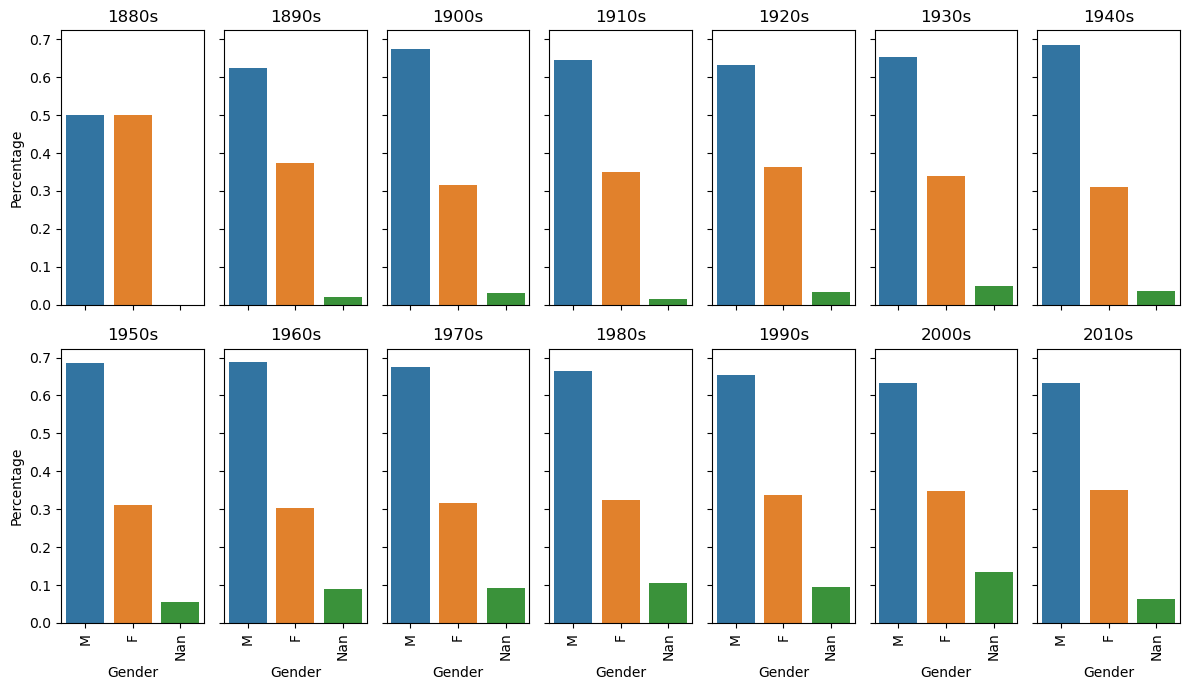

In [199]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 7, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()
colors = {}

for i, decade in enumerate(decades):
    # get top k ethnicites
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    x = ['M', 'F', 'Nan']
    y = [df_decade['m_ratio'].mean(), df_decade['f_ratio'].mean(), df_decade['nan_ratio'].mean()]

    
    # for ethnicity in df_top_k['ethnicity_name'].values:
    #     if ethnicity not in colors:
    #         colors[ethnicity] = sns.color_palette(n_colors=40)[len(colors)-1]

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i])

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Gender')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # pretty label display
    # patches = [matplotlib.patches.Patch(color=sns.color_palette()[j], label=t) for j,t in enumerate(t.get_text() for t in ax[i].get_xticklabels())]
    # ax[i].legend(handles=patches, loc="upper right") 

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

plt.tight_layout()
plt.show()

# TODO add confidence intervals

In [ ]:
# # add column that contains the number of actors in every movie
# # count number of actors in the movie
# df_number_actor = df.groupby('wiki_movie_id')[['a_name']].count()

# # transform datatype of the column from integer to object
# df_number_actor['a_name'] = df_number_actor['a_name'].apply(str)

# # rename the column accordingly
# df_number_actor = df_number_actor.rename(columns={'a_name': 'number_actors'})
# print(df_number_actor.head())

# # merge df and df_number_actor by wiki_movie_id (wiki_movie_id = column of df; wiki_movie_id = index of df_number_actor)
# # df = df.merge(df_number_actor, left_on='wiki_movie_id', right_index=True)

In [ ]:
# # print df with the new column that contains the number of actors
# print(df.shape)
# df.head()